In [329]:
import random
import numpy as np
from tqdm import tqdm
import torch as T
import torch.nn as nn

import unicodedata
from glob import glob
from collections import defaultdict

from torch.utils.data import Dataset, DataLoader

In [171]:
glob('names/*.txt')

['names\\Arabic.txt',
 'names\\Chinese.txt',
 'names\\Czech.txt',
 'names\\Dutch.txt',
 'names\\English.txt',
 'names\\French.txt',
 'names\\German.txt',
 'names\\Greek.txt',
 'names\\Irish.txt',
 'names\\Italian.txt',
 'names\\Japanese.txt',
 'names\\Korean.txt',
 'names\\Polish.txt',
 'names\\Portuguese.txt',
 'names\\Russian.txt',
 'names\\Scottish.txt',
 'names\\Spanish.txt',
 'names\\Vietnamese.txt']

In [172]:
EOS_TOKEN = 27 #end of string

char_to_code = defaultdict(int)
for c in range(97, 97 + 26):
    char_to_code[chr(c)] = c - 97 + 1

def prepare_txt(s):
    return unicodedata.normalize('NFKD', s.split('\n')[0]).\
            encode('ASCII', 'ignore').lower().decode()

def str_to_code(s):
    return list(map(lambda x: char_to_code[x], s)) + [EOS_TOKEN]

In [565]:
#char_to_code

In [499]:
def shuffle_return(L):
    L = [v for v in L] #copy
    random.Random(23).shuffle(L)
    return L

class NamesDataset(Dataset):
    def __init__(self, filename=None, train=True):
        """filname : if None, then load all the files. 
           train : if True, then buil train dataset else test dataset
        """
        if filename:
            all_files = open(filename, encoding="utf-8") 
            data = list(map(lambda s: str_to_code(prepare_txt(s)), all_files))
            y = list(range(len(data)))
            data_y = [[y[i]] * len(d) for i, d in enumerate(data)]
            data_y = [val for sublist in data_y for val in sublist]
        else: 
            all_files = [open(f, encoding="utf-8") for f in glob('names/*.txt')]
            data = [list(map(lambda s: str_to_code(prepare_txt(s)), f)) 
                    for f in all_files]
            data = [shuffle_return(v) for v in data]
            max_len = min(map(len, data))
            data = [v[:max_len * 2] for v in data]
            y = list(range(len(data)))
            data_y = [ [y[i]]*len(d)   for i, d in enumerate(data)]
            data_y = [val for sublist in data_y for val in sublist]
            data = [val for sublist in data for val in sublist]
        self.classes = all_files  
        z = list(zip(data, data_y))
        random.Random(4).shuffle(z)
        data, data_y = np.array(list(zip(*z)))
        self.data_x = data[:int(len(data) * .8)] if train else data[int(len(data) * .8):]
        self.data_y = data_y[:int(len(data_y) * .8)] if train else data_y[int(len(data_y) * .8):]
                
    def __getitem__(self, index):  #ds[5]
        return T.tensor(self.data_x[index]), self.data_y[index]

    def __len__(self):
        return len(self.data_x)

def collate_fn(data):
    maximum = max(list(map(lambda x: len(x[0]), data)))
    return T.tensor(list(map(lambda d: list(d[0])+(maximum-len(d[0]))*[EOS_TOKEN], data))), list(zip(*data))[1]

In [503]:
ds = NamesDataset()
ds_test = NamesDataset(train=False)
#ds = NamesDataset(None)
dl = DataLoader(ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
dl_test = DataLoader(ds_test, batch_size=1, collate_fn=collate_fn)

1902

476



In [504]:
def one_hot_char(x, char_to_code):
    embd = [0]*(len(set(char_to_code.values())) + 1)
    embd[x] = 1
    return embd

def one_hot_string(seq, char_to_code):
    res = []
    for x in seq: 
        res.append(one_hot_char(x, char_to_code))
    return res

def one_hot_batch(x_batch):
    res = []
    for i, _ in enumerate(x_batch):
        res.append(one_hot_string(x_batch[i], char_to_code))
    return T.tensor(res).float()         

(one_hot_batch(x).shape)

torch.Size([14, 12, 28])

In [568]:
class CORnn(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(CORnn, self).__init__() 
        self.hidden_size = hidden_size
        self.nb_layer = 3
        self.input_size = input_size #28
        self.output_size = output_size #28
        
        self.i2h = nn.Linear(self.hidden_size + self.input_size, self.hidden_size)
        #self.i2o = nn.Linear(self.hidden_size + self.input_size, self.input_size)
        self.i2o = nn.Sequential(
        nn.Linear(self.hidden_size + self.input_size, self.hidden_size),
        nn.ReLU(),
        nn.Linear(self.hidden_size, self.output_size)
        )
        self.softmax = nn.LogSoftmax()
        self.relu = nn.ReLU()
      
    def forward(self, input_x, hidden):
        x = T.cat((input_x, hidden), 1)
        hidden = self.relu(self.i2h(x))
        output = self.softmax(self.i2o(x))
        return output, hidden

    def init_hidden(self, batch_size=1):
        return T.zeros(batch_size, self.hidden_size)   

In [569]:
from tqdm import trange

rnn = CORnn(input_size=28, output_size=28, hidden_size=128)
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.NLLLoss()
hidden = rnn.init_hidden()
optimizer = T.optim.Adam(rnn.parameters())#, lr=1e-2)
epoch = 50

train_history, test_history = [], []
train_acc, test_acc = [], []
for epoch in trange(epoch):
    batch_history = []
    batch_acc = []
    for x, y in dl:
        hidden  = rnn.init_hidden(batch_size=x.shape[0])
        outputs = T.zeros((x.shape[1], x.shape[0], 28))

        optimizer.zero_grad()
        
        input_x = one_hot_batch(x)
        for i in range(x.shape[1]):
            #pass the word throught the network
            output, hidden = rnn(input_x[:, i], hidden)
            outputs[i] = output

        #calcul du mask
        m = T.zeros((x.shape[1], x.shape[0], 28))
        m.requires_grad = False
        for i, idx in enumerate([list(x.numpy()[i]).index(27) - 1 for i in range(len(x))]):
            m[idx, i] = 1.

        #get the final prediction for each word
        yhat = (m * outputs).sum(dim=0)

        #compute loss
        loss = loss_function(yhat, T.tensor(y))
        loss.backward()
        optimizer.step()
        batch_acc.append((yhat.max(1)[1].numpy() == np.array(y)).mean())
        batch_history.append(loss.item())
    
    train_history.append(np.array(batch_history).mean())
    train_acc.append(np.array(batch_acc).mean())
    
    #eval
    batch_history = []
    batch_acc= []
    for x, y in dl_test:
        hidden  = rnn.init_hidden(batch_size=x.shape[0])
        outputs = T.zeros((x.shape[1], x.shape[0], 28))
        
        input_x = one_hot_batch(x)
        for i in range(x.shape[1]):
            #pass the word throught the network
            output, hidden = rnn(input_x[:, i], hidden)
            outputs[i] = output

        #calcul du mask
        m = T.zeros((x.shape[1], x.shape[0], 28))
        m.requires_grad = False
        for i, idx in enumerate([list(x.numpy()[i]).index(27) - 1 for i in range(len(x))]):
            m[idx, i] = 1.

        #get the final prediction for each word
        yhat = (m * outputs).sum(dim=0)

        #compute loss
        loss = loss_function(yhat, T.tensor(y))

        batch_history.append(loss.item())
        batch_acc.append((yhat.max(1)[1].numpy() == np.array(y)).mean())
        
    test_history.append(np.array(batch_history).mean())
    test_acc.append(np.array(batch_acc).mean())
        






  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\kherf\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



  2%|▏         | 1/50 [00:01<01:11,  1.46s/it]


  4%|▍         | 2/50 [00:02<01:05,  1.37s/it]


  6%|▌         | 3/50 [00:03<01:02,  1.33s/it]


  8%|▊         | 4/50 [00:05<01:00,  1.31s/it]


 10%|█         | 5/50 [00:06<00:59,  1.33s/it]


 12%|█▏        | 6/50 [00:08<00:58,  1.34s/it]


 14%|█▍        | 7/50 [00:09<00:59,  1.39s/it]


 16%|█▌        | 8/50 [00:11<00:59,  1.42s/it]


 18%|█▊        | 9/50 [00:13<00:59,  1.44s/it]


 20%|██        | 10/50 [00:14<00:58,  1.46s/it]


 22%|██▏       | 11/50 [00:15<00:56,  1.45s/it]


 24%|██▍       | 12/50 [00:17<00:55,  1.45s/it]


 26%|██▌       | 13/50 [00:18<00:53,  1.44s/it]


 28%|██▊       | 14/50 [00:20<00:51,  1.44s/it]


 30%|███       | 15/50 [00:21<00:49,  1.43s/it]


 32%|███▏      | 16/5

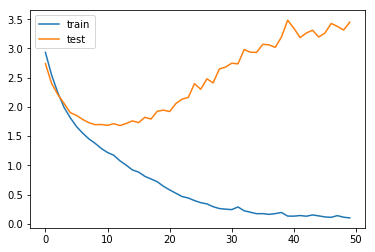

In [570]:
import matplotlib.pyplot as plt

plt.plot(train_history, label="train")
plt.plot(test_history, label="test")
plt.legend()
plt.show()

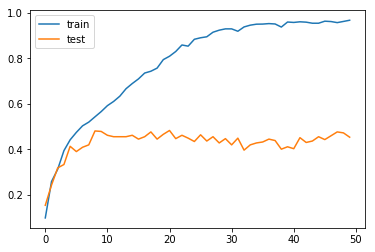

In [571]:
plt.plot(train_acc, label="train")
plt.plot(test_acc, label="test")
plt.legend()
plt.show()  


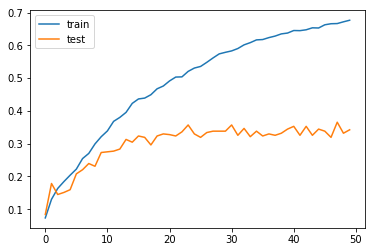

In [564]:
plt.plot(train_acc, label="train")
plt.plot(test_acc, label="test")
plt.legend()
plt.show()  


In [561]:
train_acc

[0.0625,
 0.09873949579831932,
 0.11186974789915967,
 0.1323529411764706,
 0.14045618247298922,
 0.13865546218487396,
 0.17024309723889558,
 0.13655462184873948,
 0.19620348139255703,
 0.18277310924369747,
 0.2186374549819928,
 0.17436974789915966,
 0.25060024009603843,
 0.22268907563025211,
 0.28016206482593037,
 0.24369747899159663,
 0.328781512605042,
 0.2668067226890756,
 0.3482142857142857,
 0.2605042016806723,
 0.35339135654261705,
 0.2668067226890756,
 0.38340336134453784,
 0.28991596638655465,
 0.39653361344537813,
 0.29411764705882354,
 0.4206182472989196,
 0.31092436974789917,
 0.42339435774309725,
 0.34243697478991597,
 0.4431272509003601,
 0.33403361344537813,
 0.45873349339735897,
 0.32142857142857145,
 0.45783313325330127,
 0.3130252100840336,
 0.4615096038415366,
 0.32563025210084034,
 0.4808673469387755,
 0.3088235294117647,
 0.4893457382953181,
 0.32142857142857145,
 0.4957232893157263,
 0.3277310924369748,
 0.49587334933973587,
 0.3277310924369748,
 0.498874549819928,